In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds

# Part 5: Idiosyncratic Volatility Strategy (IV)

In [47]:
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])

In [48]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,8096.000,NaN,0.002928,-0.019258,1,-0.209825,-0.022186
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,10055.750,8096.0000,0.003030,0.006407,1,-0.208509,0.003377
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,12656.375,10055.7500,0.002920,0.013414,1,-0.173375,0.010494
3,10028,1992-03-31,0.419355,5548.0,2.75000,15257.000,12656.3750,0.003343,-0.023699,1,0.416012,-0.027042
4,10028,1998-05-29,0.047619,4151.0,2.75000,11415.250,15257.0000,0.003806,-0.025746,1,0.043813,-0.029552
...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93152,2017-10-31,-0.321678,29888.0,0.97000,28991.360,14937.5581,0.000837,0.019275,1,-0.322515,0.018438
1439404,93152,2017-09-29,-0.239362,29888.0,1.43000,42739.840,28991.3600,0.000799,0.023729,1,-0.240161,0.022930
1439405,93152,2017-08-31,-0.271318,29888.0,1.88000,56189.440,42739.8400,0.000926,0.001600,1,-0.272244,0.000674
1439406,93152,2017-07-31,0.044534,29887.0,2.58000,77108.460,56189.4400,0.000811,0.020277,1,0.043723,0.019466


In [49]:
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [50]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-31,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918
...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93426,2023-08-31,-0.037156,12581.0,36.0200,453167.6200,422469.9800,0.004463,-0.020605,1,-0.041619,-0.025068
1439404,93426,2023-09-29,-0.067740,12581.0,33.5800,422469.9800,376423.5200,0.004472,-0.047390,1,-0.072212,-0.051862
1439405,93426,2023-10-31,-0.108993,12581.0,29.9200,376423.5200,381429.9000,0.004475,-0.028867,1,-0.113468,-0.033342
1439406,93426,2023-11-30,0.019051,12510.0,30.4900,381429.9000,426215.7000,0.004455,0.092057,1,0.014596,0.087602


### Computing the betas

In [51]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# 4. Drop raws that contain nan in column beta
data = data.dropna(subset=['beta']).copy()

In [52]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta
36,10001,2013-01-31,0.062701,8157.0,9.87,80509.59,81080.58,0.000051,0.054142,1,0.062650,0.054091,0.464682
37,10001,2013-02-28,0.011651,8157.0,9.94,81080.58,83201.40,0.000040,0.008282,1,0.011611,0.008242,0.484416
38,10001,2013-03-28,0.030684,8157.0,10.20,83201.40,86668.70,0.000034,0.035295,1,0.030650,0.035261,0.484182
44,10001,2013-09-30,0.004412,10372.0,10.20,105794.40,103408.84,0.000017,0.037497,1,0.004395,0.037480,0.479719
48,10001,2014-01-31,0.147572,10452.0,9.17,95844.84,97830.72,0.000042,-0.030020,1,0.147530,-0.030062,0.429576
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420776,93426,2022-12-30,-0.047326,12551.0,38.65,485096.15,541952.18,0.003326,-0.057120,1,-0.050652,-0.060446,1.318557
1420778,93426,2023-02-28,0.009727,12551.0,43.60,547223.60,524296.80,0.003682,-0.024666,1,0.006045,-0.028348,1.312768
1420782,93426,2023-06-30,0.063860,12577.0,37.15,467235.55,470505.57,0.004302,0.066183,1,0.059558,0.061881,1.322365
1420784,93426,2023-08-31,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988


In [53]:
#count beta not nan
print(data['beta'].count())

len(data['beta'])

403320


403320

### Computing the idiosyncratic volatility

In [54]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return', 'residuals'])

# Drop nans in the idiosyncratic_volatility column
data = data.dropna(subset=['idiosyncratic_volatility']).copy()

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [55]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta,idiosyncratic_volatility
56,10006,1976-04-30,0.012658,5783.0,50.000,289150.000,280475.500,0.003911,-0.010402,1,0.008747,-0.014313,1.138632,0.067655
57,10006,1976-07-30,-0.052265,8675.0,34.000,294950.000,291696.875,0.004235,-0.006136,1,-0.056500,-0.010371,1.125851,0.067044
58,10006,1976-09-30,0.040892,8675.0,35.000,303625.000,277600.000,0.004235,0.024513,1,0.036657,0.020278,1.088614,0.066209
59,10006,1977-01-31,0.014235,8675.0,35.625,309046.875,298203.125,0.003793,-0.036326,1,0.010442,-0.040119,1.118446,0.066035
60,10006,1977-02-28,-0.022456,8675.0,34.375,298203.125,299287.500,0.003691,-0.015744,1,-0.026147,-0.019435,1.112080,0.065183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403315,93426,2022-12-30,-0.047326,12551.0,38.650,485096.150,541952.180,0.003326,-0.057120,1,-0.050652,-0.060446,1.318557,0.077647
403316,93426,2023-02-28,0.009727,12551.0,43.600,547223.600,524296.800,0.003682,-0.024666,1,0.006045,-0.028348,1.312768,0.076813
403317,93426,2023-06-30,0.063860,12577.0,37.150,467235.550,470505.570,0.004302,0.066183,1,0.059558,0.061881,1.322365,0.076120
403318,93426,2023-08-31,-0.037156,12581.0,36.020,453167.620,422469.980,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988,0.075317


## Sorting

In [56]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

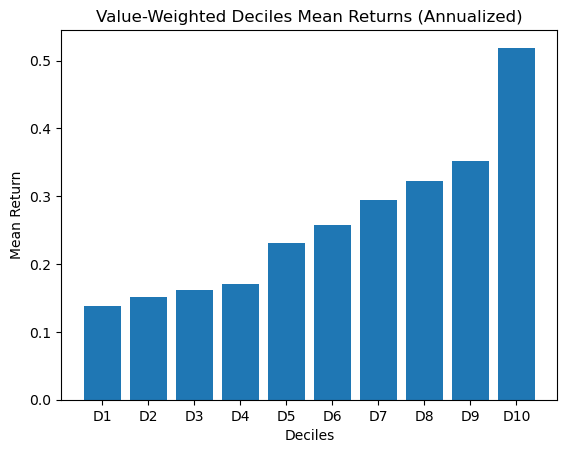

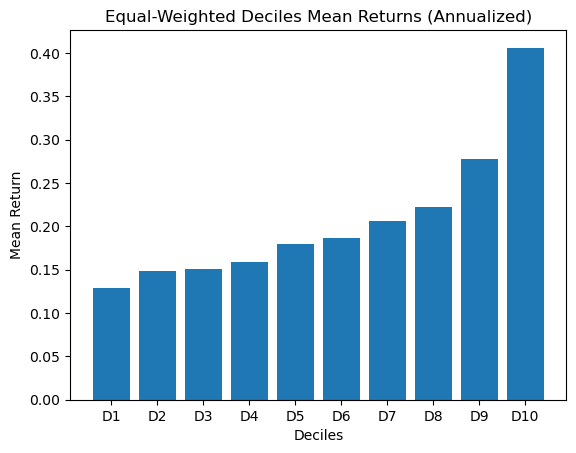

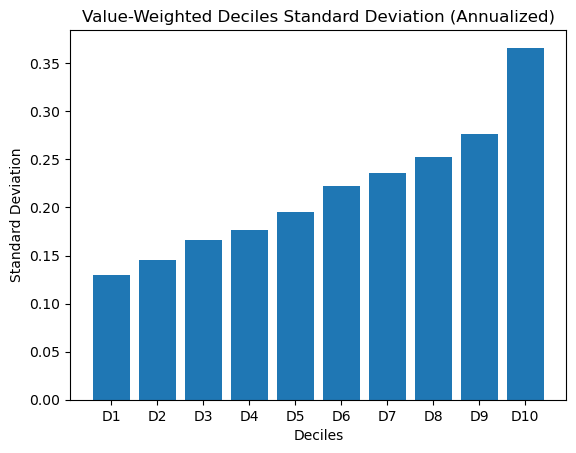

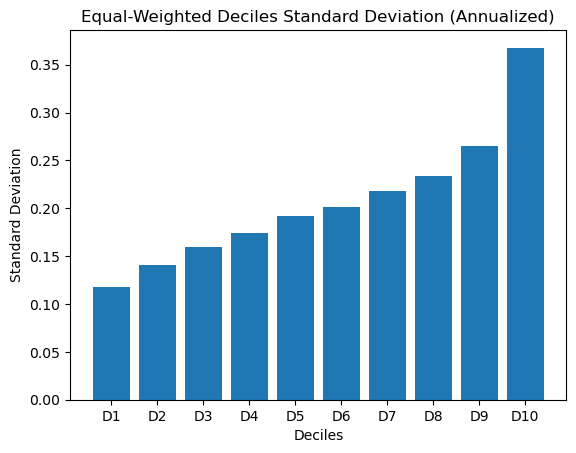

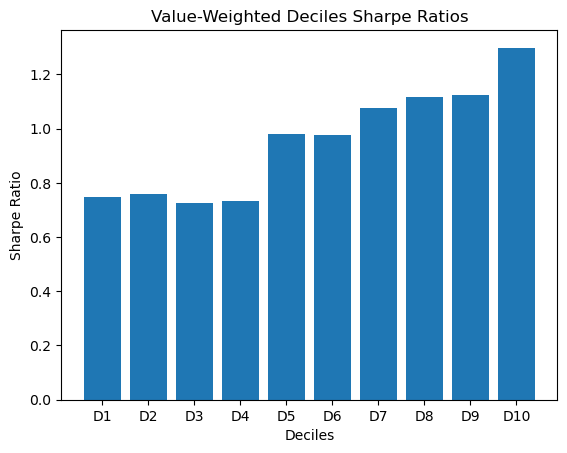

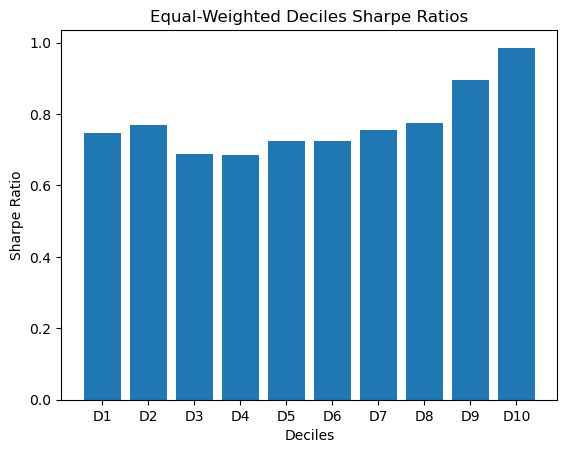

In [58]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('ew_sharpe_ratio.png')
plt.show()

### Factor creation

In [65]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].sum().reset_index()
short_leg = data[data['IV_Q'] <= 3].groupby('date')['Rn'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean()
short_mean = short_leg['Rn'].mean()

long_mean_e = long_leg['excess'].mean()
short_mean_e = short_leg['excess'].mean()

long_std = long_leg['Rn'].std()
short_std = short_leg['Rn'].std()

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg - short_leg
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['Rn'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 7.709086118483412
Short Leg Mean Return: 5.615428881516587
Long Leg Standard Deviation: 24.1976341802437
Short Leg Standard Deviation: 18.384128026343024
Long Leg Sharpe Ratio: 0.31833085309804
Short Leg Sharpe Ratio: 0.3051108155114511
Factor Mean Return: 2.0936572369668256
Factor Standard Deviation: 14.904914854796976
Factor Sharpe Ratio: 0.14004941795174822


In [67]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 2.040409377621139
P-Value: 0.020654784335738863
The factor strategy has an average return that is statistically significantly different from zero.
